In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding Path (Decoder)
        self.decoder4 = self.conv_block(1024, 512)
        self.decoder3 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder1 = self.conv_block(128, 64)

        # Final Output Layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

        # Max Pooling for downsampling
        self.maxpool = nn.MaxPool2d(2)

        # Upsampling for upscaling with align_corners=True
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.maxpool(enc1))
        enc3 = self.encoder3(self.maxpool(enc2))
        enc4 = self.encoder4(self.maxpool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.maxpool(enc4))

        # Expanding Path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection
        dec1 = self.decoder1(dec1)

        # Output Layer (make sure it's single-channel for binary segmentation)
        out = self.output_layer(dec1)
        return out
transform = transforms.Compose([
    transforms.Resize((544, 832)),
    transforms.ToTensor(),  # Handles PIL -> Tensor and channel dimensions
])

<ipython-input-12-726a91b8493d>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/unet_iteration_attention.pth", map


Validation Metrics:
Loss: 0.6514
Dice Score: 0.2636
IoU: 0.1546
Accuracy: 0.7421
Precision: 0.9147
Recall: 0.1662
F1-Score: 0.2812


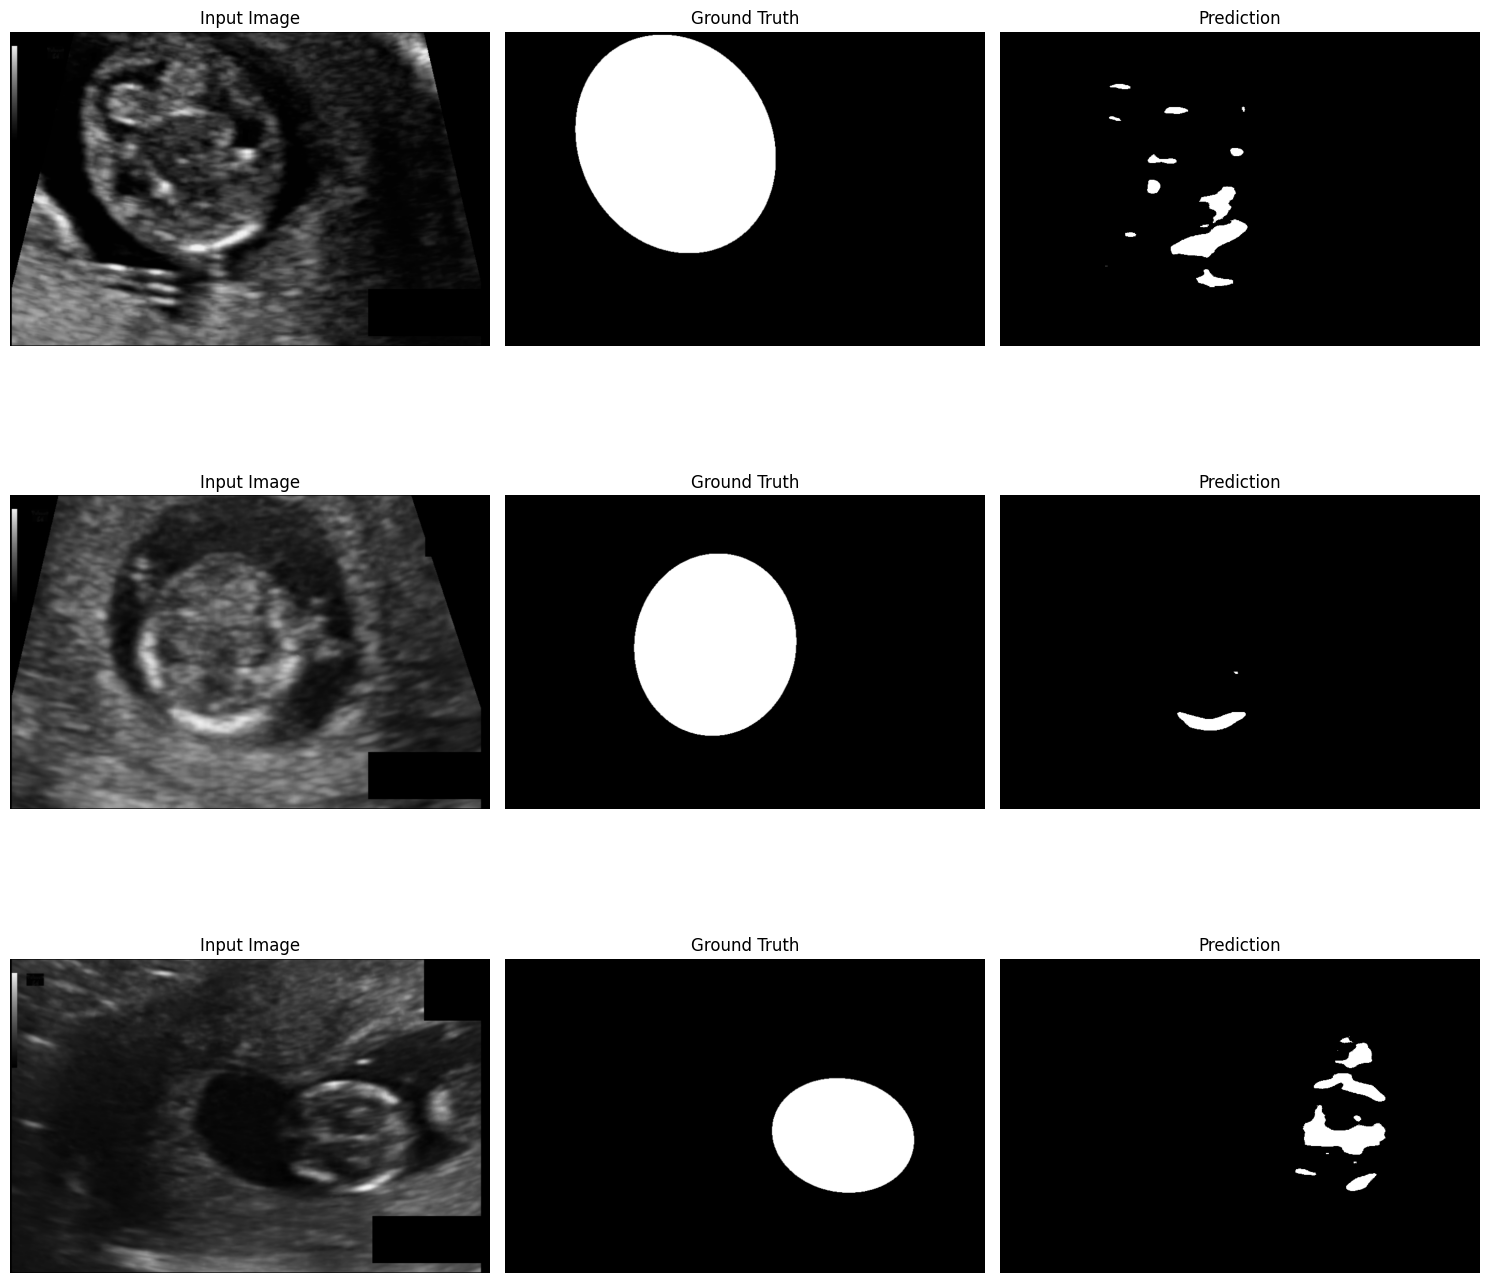

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import seaborn as sns
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/unet_iteration_attention.pth", map_location=device))
model.eval()

def validate_model(model, test_loader, device, threshold=0.5):
    """
    Validate segmentation model with metrics (RAM-optimized)
    Returns:
        metrics_dict: Dictionary of calculated metrics
        sample_images: List of sample predictions
    """
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_iou = 0.0

    # Initialize confusion matrix components
    TP = FP = TN = FN = 0
    sample_images = []

    # Define metrics calculations
    def dice_score(preds, targets):
        smooth = 1e-6
        intersection = (preds * targets).sum()  # Use multiplication instead of &
        return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

    def iou_score(preds, targets):
        smooth = 1e-6
        intersection = (preds * targets).sum()  # AND replaced with multiplication
        union = (preds + targets - preds * targets).sum()  # OR equivalent
        return (intersection + smooth) / (union + smooth)

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(test_loader, desc="Validation")):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Convert to probabilities and binary mask
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()  # Already 0/1 float tensor

            # Calculate metrics
            current_dice = dice_score(preds, masks)
            current_iou = iou_score(preds, masks)
            total_dice += current_dice.item()
            total_iou += current_iou.item()

            # Update confusion matrix components using boolean masks
            y_true = (masks > threshold)  # Boolean tensor
            y_pred = (preds > threshold)  # Boolean tensor

            TP += torch.logical_and(y_pred, y_true).sum().item()
            FP += torch.logical_and(y_pred, ~y_true).sum().item()
            TN += torch.logical_and(~y_pred, ~y_true).sum().item()
            FN += torch.logical_and(~y_pred, y_true).sum().item()

            # Store samples for visualization
            if i < 2:  # Store first 2 batches only
                sample_images.extend(zip(
                    images.cpu().numpy(),
                    masks.cpu().numpy(),
                    preds.cpu().numpy()
                ))

            # Cleanup
            del images, masks, outputs, probs, preds, y_true, y_pred
            torch.cuda.empty_cache()

    # Calculate final metrics (same as before)
    num_batches = len(test_loader)
    eps = 1e-6

    accuracy = (TP + TN) / (TP + FP + TN + FN + eps)
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1_score = 2 * (precision * recall) / (precision + recall + eps)

    metrics = {
        'loss': total_loss / num_batches,
        'dice': total_dice / num_batches,
        'iou': total_iou / num_batches,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score,
    }

    return metrics, sample_images

def visualize_results(sample_images, num_samples=3):
    """Visualize sample predictions with ground truth"""
    plt.figure(figsize=(15, 5*num_samples))

    for i in range(num_samples):
        img, true_mask, pred_mask = sample_images[i]

        # Convert from tensor to numpy format
        img = np.transpose(img, (1, 2, 0))  # CHW to HWC
        true_mask = true_mask.squeeze()
        pred_mask = pred_mask.squeeze()

        # Plot
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_targets, all_preds):
    """Plot confusion matrix"""
    cm = confusion_matrix(np.array(all_targets) > 0.5,
                         np.array(all_preds) > 0.5)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Foreground'],
                yticklabels=['Background', 'Foreground'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Usage Example
if __name__ == "__main__":
    # Load your trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=3, out_channels=1).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/unet_iteration_attention.pth', map_location=device))

    # Create test dataset and loader (modify as needed)
    test_transform = transforms.Compose([
        transforms.Resize((544, 832)),
        transforms.ToTensor(),
    ])

    class TestDataset(Dataset):
        def __init__(self, img_dir, mask_dir, transform=None):
            self.img_dir = img_dir
            self.mask_dir = mask_dir
            self.transform = transform
            self.img_names = sorted(os.listdir(img_dir))

        def __len__(self):
            return len(self.img_names)

        def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_names[idx])
            mask_path = os.path.join(self.mask_dir, self.img_names[idx])

            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            return image, mask

    test_dataset = TestDataset(
        img_dir='/content/drive/MyDrive/train_test_split/test_images',
        mask_dir='/content/drive/MyDrive/train_test_split/test_annotations',
        transform=test_transform
    )

    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Run validation
    metrics, sample_images = validate_model(model, test_loader, device)

    # Print metrics
    print("\nValidation Metrics:")
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"Dice Score: {metrics['dice']:.4f}")
    print(f"IoU: {metrics['iou']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1-score']:.4f}")

    # Visualize results
    visualize_results(sample_images, num_samples=3)
    # plot_confusion_matrix(all_targets, all_preds)